In [1]:
# Append base directory
import os,sys,inspect
rootname = "snippets-data-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# Import base libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from time import time

# Import local libraries
from lib.stat.infotheory_sample import sample_rel_area_phase_space, sample_entropy_uniform_binning, sample_entropy_adaptive_binning
from lib.stat.resample import resample_independent_vars
from lib.stat.binning import bin_multivariate_adaptive

Appended root directory /media/aleksejs/DataHDD/work/codes/snippets-data-analysis


### Binned entropy test

Question: what is the best model-free way to check if multiple simultaneusly-sampled parameters are completely unrelated to each other?

**Null Hypotesis**: Data was generated from a distribution, which is a product of its marginal 1D probability distributions.

**Strategy**:
1. Get original multidimensional data X
2. Compute marginal empirical CDF for each dimension $i$ from $X_i$
3. Generate surrogate data for dimension independently, same amount as X
4. Compute entropy of data using several bin numbers
5. Compute entropy of surrogate using several bin numbers. Repeat multiple times to get bootstrap variance
6. Plot data entropy vs surrogate entropy
  * For small discretizations, both entropies will be equal to 1 due to coarseness
  * For large discretizations, entropies will be equal due to one data point per bin
  * For middle discretizations, entropy of data should be significantly smaller than surrogate, because it would naturally non-uniformly cover the phase-space.


In [2]:
# Print time, memory usage, process id and first argument before and after the function
def timing(func):
    def inner(*args, **kwargs):
        timeStart = time()
        rez = func(*args, **kwargs)
        print("-- time taken", time() - timeStart)
        return rez

    return inner

@timing
def resample_multi(data, nDiscrLst, nTrial, est_func, method):
    rezMu = []
    rezStd = []
    for nDiscr in nDiscrLst:
        est_func_wrap = lambda data: est_func(data, nDiscr)
        mu, std = resample_independent_vars(data, nTrial, est_func_wrap, method)
        rezMu += [mu]
        rezStd += [std]
    return np.array([rezMu, rezStd])


def errorPlot(ax, x, yReal, yErr, metric):
    ax.set_xlabel("Discretization")
    ax.set_title(metric)
    ax.semilogx(x, yReal)
    ax.fill_between(x, yReal-yErr, yReal+yErr,
                       alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', antialiased=True)

    
def errorPlotSurrVsReal(ax, x, yReal, yDict, metric, yAsymptotic=None):
    ax.set_xlabel("Discretization")
    ax.set_title(metric)
    if yAsymptotic is not None:
        ax.axhline(y=yAsymptotic, linestyle='--', label="asymptotic")
    ax.semilogx(x, yReal, label="data")
    for method, (ySurr, yErr) in yDict.items():
        ax.semilogx(x, ySurr, label=method)
        ax.fill_between(x, ySurr-yErr, ySurr+yErr,
                           alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', antialiased=True)
    ax.legend()

In [3]:
# Create data for noisy circular process
nData = 1000
theta = np.random.uniform(0, 1, nData)
er = np.random.normal(0, 0.1, nData)
x = (1+er)*np.cos(2*np.pi*theta)
y = (1+er)*np.sin(2*np.pi*theta)
# x = np.random.normal(0, 1, nData)
# y = np.random.normal(0, 1, nData)
dataReal = np.vstack((x, y)).transpose()

Computing relArea using resample
-- time taken 0.6832170486450195
Computing relArea using shuffle
-- time taken 0.6776714324951172
Computing entropy using semi-analytic
-- time taken 0.9731898307800293
Computing entropy using resample
-- time taken 0.7575345039367676
Computing entropy using shuffle
-- time taken 0.6430809497833252


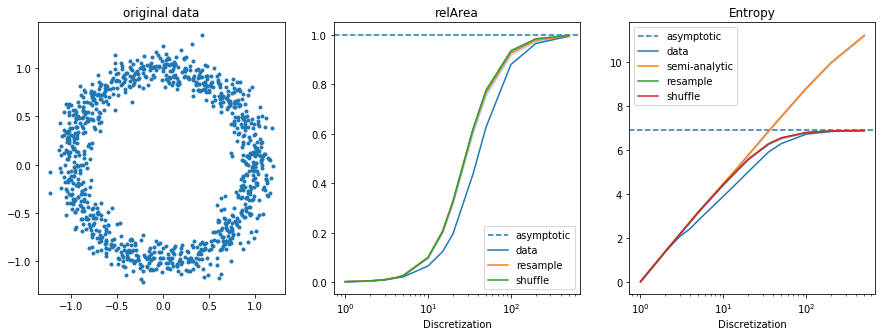

In [18]:
# Compute binned entropy for actual data
# nDiscrLst = np.array(list(range(2, 40)))
nDiscrLst = [1, 2, 3, 4, 5, 10, 15, 20, 35, 50, 100, 200, 500]
nTrial = 100

relAreaReal = np.array([sample_rel_area_phase_space(dataReal, nDiscr) for nDiscr in nDiscrLst])
entropyReal = np.array([sample_entropy_uniform_binning(dataReal, nDiscr) for nDiscr in nDiscrLst])

relAreaAsymptotic = 1
entropyAsymptotic = np.log(nData)

# Compute relative phase space area for scrambled data
surrAreaDict = {}
for method in ["resample", "shuffle"]:
    print("Computing relArea using", method)
    surrAreaDict[method] = resample_multi(dataReal, nDiscrLst, nTrial, sample_rel_area_phase_space, method)

# Compute binned entropy for scrambled data
surrEntDict = {}
for method in ["semi-analytic", "resample", "shuffle"]:
    print("Computing entropy using", method)
    surrEntDict[method] = resample_multi(dataReal, nDiscrLst, nTrial, sample_entropy_uniform_binning, method)

# Plot stuff
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].plot(x, y, '.')
ax[0].set_title("original data")

errorPlotSurrVsReal(ax[1], nDiscrLst, relAreaReal, surrAreaDict, "relArea", relAreaAsymptotic)

errorPlotSurrVsReal(ax[2], nDiscrLst, entropyReal, surrEntDict, "Entropy", entropyAsymptotic)

plt.show()

Main conclusions:
* **Important!** Semi-analytic surrogate estimate of the maximum entropy of multidimensional data suffers much less from finite data size than the sample entropy or other surrogate estimators, as the probability of having at most 1 data point per bin is exponentially smaller in 1D case than in ND case. Thus, while semi-analytic method is significantly faster than the other methods, it is useless in practice as it is not comparable to sample entropy.
* Resample is slightly faster than shuffle, and the difference between them is negligible.
* Relative area measures more or less the same thing, but is less sensitive to variation of density, unless the density is exactly zero, so entropy is more solid. But perhaps it is also useful?

We can thus plot the generalized mutual information, and see if it is significantly above 0 for most of the values.

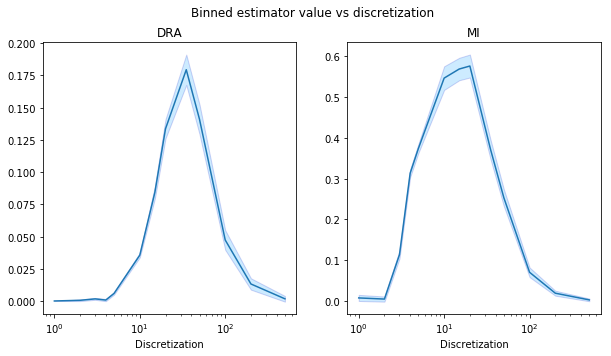

In [20]:
sampleMI  = surrEntDict["resample"][0]-entropyReal
sampleDRA = surrAreaDict["resample"][0]-relAreaReal

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Binned estimator value vs discretization")

errorPlot(ax[0], nDiscrLst, sampleDRA, surrAreaDict["resample"][1], "DRA")
errorPlot(ax[1], nDiscrLst, sampleMI, surrEntDict["resample"][1], "MI")

plt.show()

Here's a funny idea. What if instead of keeping the width of the bin fixed, we keep the number of points fixed.

1. Take some axis, sort points wrt that axis
2. Split points in half according to that axis
3. Continue recursively with (1.) using a different axis
4. If number of points in current bin is the expected number or lower, finish and return that bin

The general form of differential entropy using non-equal bins is

$$
H
= -\int \rho \log \rho dV
\approx -\sum_i \rho_i \Delta V_i \log \rho_i
= -\sum_i p_i \log \frac{p_i}{\Delta V_i}
= \log V - \sum_i p_i \log \frac{p_i}{q_i}
= \log V - D_{KL}(\vec{p} || \vec{q})
$$
where $q_i = \frac{\Delta V_i}{V}$. In the simple example, where all bins have the same size, we get the classical $q_i = \frac{1}{N}$ and

$$H_{Uniform} = \log \frac{V}{N} - \sum_i p_i \log p_i$$

On the other extremum, we can use the splitting algorithm until there is exactly 1 point per bin. In this case $p_i = \frac{1}{N}$ and 

$$ H_{Adapt} = \log NV + \frac{1}{N} \sum_i \log q_i $$

**Advantages**
* The cool part it that it is (kind of) non-parametric, because the best results are achieved when there is exactly 1 point per bin. So, compared to the uniform binning algorithm, there is no need to search for the optimal bin size

**Challenges**
* How much of a cheat is it to select bins after the data has been aquired, even if it is a formal procedure?
* Sensitivity to the order of dimensions during bisection is unclear
* Sensitivity to the number of data points is unclear

-- time taken 6.252450466156006


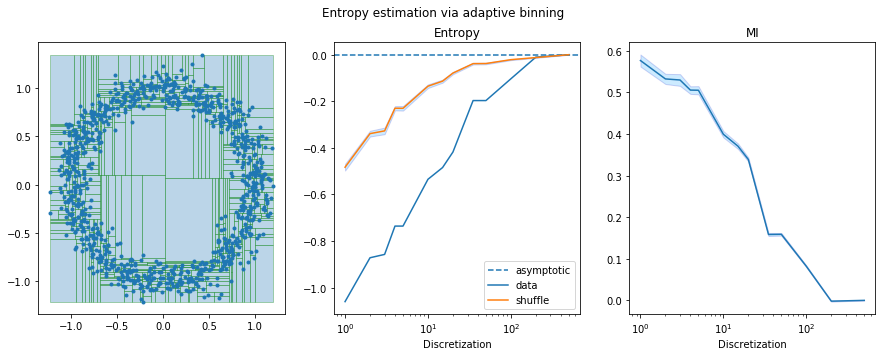

In [19]:
# try adaptive binning
nDiscrLst = [1, 2, 3, 4, 5, 10, 15, 20, 35, 50, 100, 200, 500]
entrAdaptAsymp = 0

nPointLst, extLst = bin_multivariate_adaptive(dataReal, 1)
entrAdaptTrue = [sample_entropy_adaptive_binning(dataReal, nDiscr) for nDiscr in nDiscrLst]
entrAdaptSurr = resample_multi(dataReal, nDiscrLst, nTrial, sample_entropy_adaptive_binning, "shuffle")
sampleMIAdapt = entrAdaptSurr[0]-entrAdaptTrue

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
fig.suptitle("Entropy estimation via adaptive binning")

# Plot example adaptive binning
ax[0].plot(x, y, '.')

rectangles = [Rectangle((ext[0,0], ext[0,1]), ext[1,0]-ext[0,0], ext[1,1]-ext[0,1]) for ext in extLst]
pc = PatchCollection(rectangles, alpha=0.3, edgecolor='g') #facecolor=facecolor, , edgecolor=edgecolor)
ax[0].add_collection(pc)

# Plot Estimated vs shuffle
errorPlotSurrVsReal(ax[1], nDiscrLst, entrAdaptTrue, {"shuffle" : entrAdaptSurr}, "Entropy", entrAdaptAsymp)

# Plot mutual info
errorPlot(ax[2], nDiscrLst, sampleMIAdapt, entrAdaptSurr[1], "MI")

plt.show()

Other Literature

* Kernel Density Estimation (KDE): Approximate PDE convolving sampled data with a kernel.
  - And using numerical integration to compute PDE - Very computationally intensive, not used
  - And sampling resulting PDE at real data points - used
  - And using cross-validation (e.g. average of all estimates when leaving one out)
      * Estimating good kernel width is a major difficulty. Problem only solved for dim=1 and to some extent for dim=2
* Inter-sample interval
  - 1D version of what I did above. Seems legit, except review seems to claim it can not be extended to higher dimensions
* Nearest-Neighbor Statistics  $r_{i} = min_{j\neq i} ||X_i - X_j||$. So far seems to be the goto method for entropy estimation
  - Kozachenko-Leonenko show that $H \approx \frac{1}{n}\sum_i \log r_i + \log n + const$
  
How to compute NNS
* Construct Quad Tree (e.g. 2D algorithm) O(n log n)
   1. Put all points into 1 cell using min-max bounding box
   2. For each cell
      * If cell contains zero points, delete it
      * If cell contains >1 point, split into 4 equal cells
      * Return all cells that have exactly 1 point
* When looking for neighbors, search nearby cells first ~ O(dn)